# Determining seasonal extent of waterbodies with Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment
* **Products used:** 
[ga_s2am_ard_3](https://explorer-aws.dea.ga.gov.au/products/ga_s2am_ard_3)

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.


## Description

The notebook demonstrates how to:

1. Load satellite data over the water body of interest
2. Calculate the water index MNDWI
3. Resample the time-series of MNDWI to seasonal medians
4. Generate an animation of the water extent time-series
5. Calculate and plot a time series of seassonal water extent (in square kilometres)
6. Find the minimum and maximum water extents in the time-series and plot them.
7. Compare two nominated time-periods, and plot where the water-body extent has changed.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map, xr_animation

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Seasonal_water_extents")

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Australia, see the [Dask notebook](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in JupyterLab* section of the [Dask notebook](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46207,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:38463,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/45227/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:37293,


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `lat`: The central latitude to analyse (e.g. -35.0958).
* `lon` : The central longitude to analyse (e.g. 149.4249).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.
* `start_year` and `end_year`: The date range to analyse (e.g. `('2017', '2020')`.


**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers Lake George near Canberra, Australia.


In [4]:
# Define the area of interest
lat = -35.0958
lon = 149.4249

lat_buffer = 0.12
lon_buffer = 0.1

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the start year and end year
start_year = "2017"
end_year = "2022-05"

## View the area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [5]:
display_map(lon_range, lat_range)

## Load cloud-masked satellite data

The code below will create a query dictionary for our region of interest, and then load Sentinel-2 satellite data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/04_Loading_data.ipynb).

In [6]:
# Create a query object
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": (-20, 20),
    "time": (start_year, end_year),
    "dask_chunks": {"time": 1, "x": 2048, "y": 2048},
}

# load Sentinel 2 data
ds = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3"],
    measurements=["green", "nbart_swir_2", "nbart_swir_3"],
    cloud_mask="s2cloudless",
    min_gooddata=0.9,
    group_by="solar_day",
    **query
)

ds

Finding datasets
    ga_s2am_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 65 out of 190 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 65 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 65, y: 1447, x: 1083)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-15T00:02:42.541000 ... 2022-0...
  * y             (y) float64 -3.926e+06 -3.926e+06 ... -3.955e+06 -3.955e+06
  * x             (x) float64 1.569e+06 1.569e+06 ... 1.591e+06 1.591e+06
    spatial_ref   int32 3577
Data variables:
    green         (time, y, x) float32 dask.array<chunksize=(1, 1447, 1083), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 dask.array<chunksize=(1, 1447, 1083), meta=np.ndarray>
    nbart_swir_3  (time, y, x) float32 dask.array<chunksize=(1, 1447, 1083), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Calculate the MNDWI water index

In [7]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index="MNDWI", collection="ga_s2_3", drop=True)

Dropping bands ['green', 'nbart_swir_2', 'nbart_swir_3']


## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the fmask layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take several minutes to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.


In [8]:
%%time
sample_frequency = "QS-DEC"  # quarterly starting in DEC, i.e. seasonal

# Resample using medians
print("Calculating MNDWI seasonal medians...")
mndwi = ds["MNDWI"].resample(time=sample_frequency).median().compute()

# Drop any all-NA seasons
mndwi = mndwi.dropna(dim="time", how="all")

Calculating MNDWI seasonal medians...
CPU times: user 1.12 s, sys: 273 ms, total: 1.39 s
Wall time: 17.2 s


### Facet plot the MNDWI time-steps

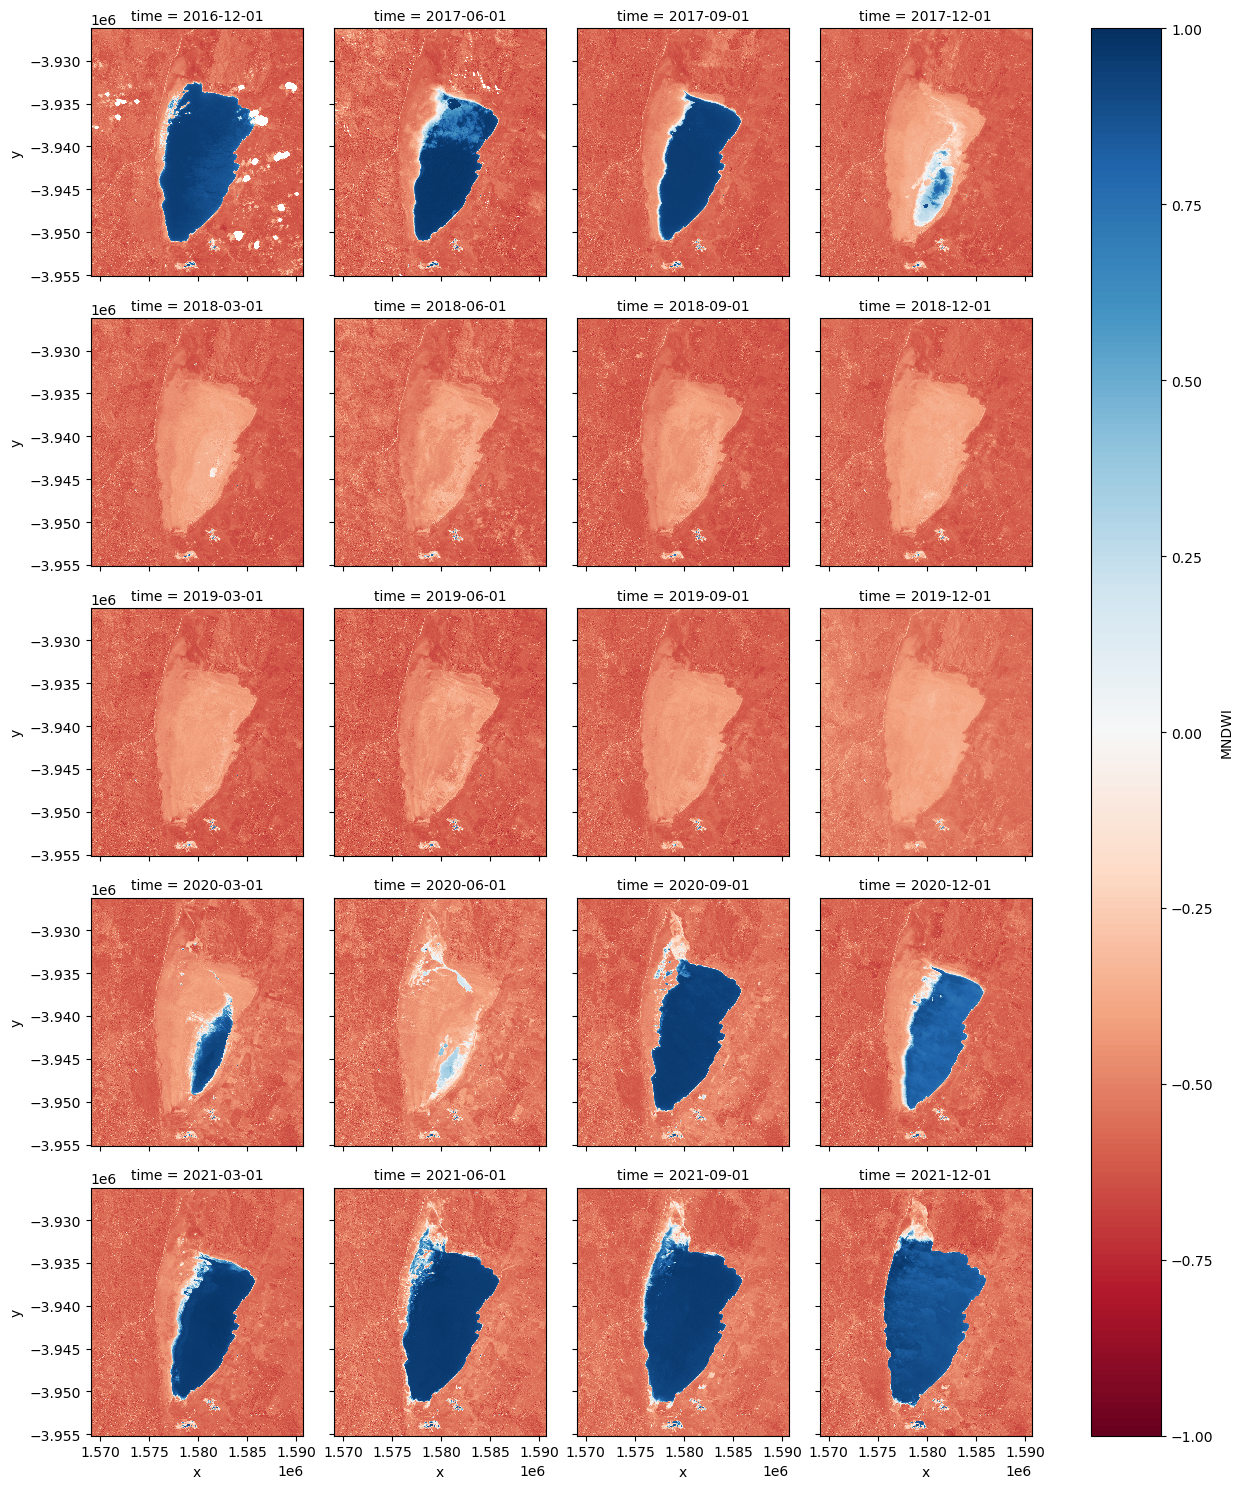

In [9]:
mndwi.plot.imshow(col="time", col_wrap=4, cmap="RdBu", vmax=1, vmin=-1);

## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [xr_animation](../How_to_guides/Animated_timeseries/) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

Exporting animation to water_extent.gif


  0%|          | 0/20 (0.0 seconds remaining at ? frames/s)

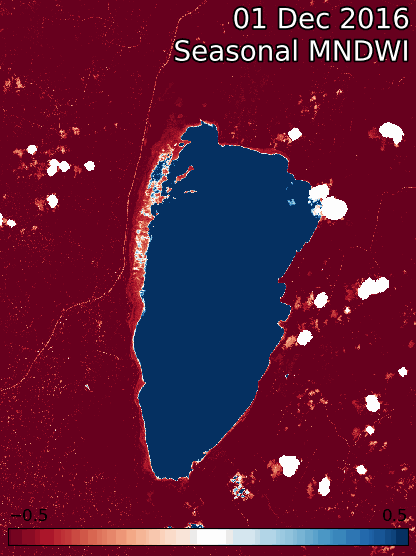

In [10]:
out_path = "water_extent.gif"

xr_animation(
    ds=mndwi.to_dataset(name="MNDWI"),
    output_path=out_path,
    bands=["MNDWI"],
    show_text="Seasonal MNDWI",
    interval=500,
    width_pixels=300,
    show_colorbar=True,
    imshow_kwargs={"cmap": "RdBu", "vmin": -0.5, "vmax": 0.5},
    colorbar_kwargs={"colors": "black"},
)

# Plot animated gif
plt.close()
Image(filename=out_path)

## Calculate the area per pixel
The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [11]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

## Calculating the extent of water

Calculates the area of pixels classified as water (if MNDWI is > 0, then water)

In [12]:
water = mndwi.where(mndwi > 0)
area_ds = water.where(np.isnan(water), 1)
ds_valid_water_area = area_ds.sum(dim=["x", "y"]) * area_per_pixel

### Plot seasonal time series from the `Start year` to `End year`

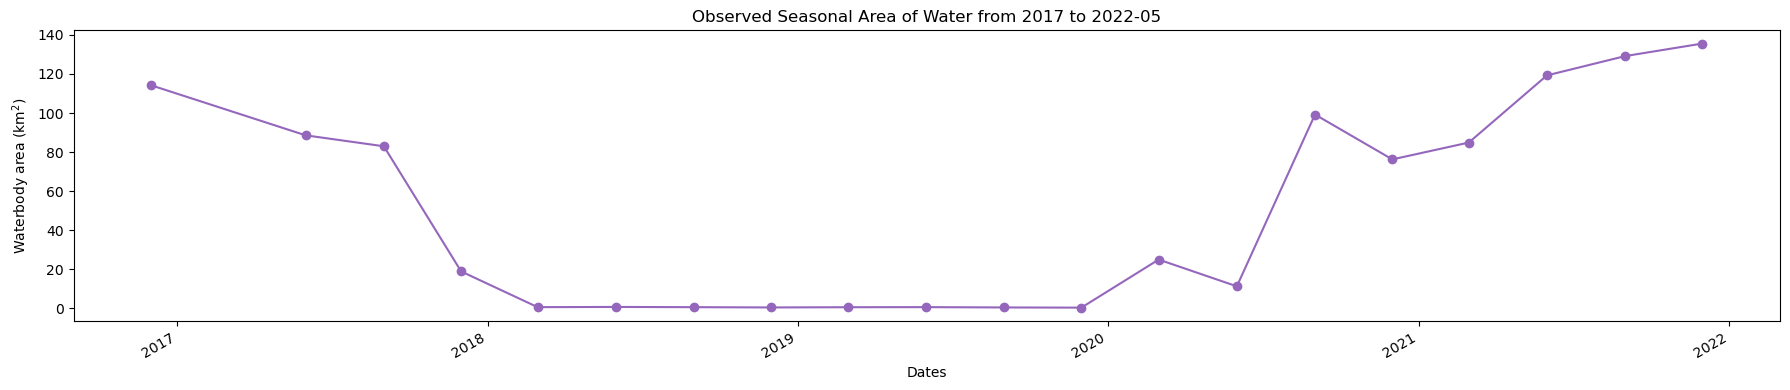

In [13]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker="o", color="#9467bd")
plt.title(f"Observed Seasonal Area of Water from {start_year} to {end_year}")
plt.xlabel("Dates")
plt.ylabel("Waterbody area (km$^2$)")
plt.tight_layout()

## Determine minimum and maximum water extent
The next cell extract the Minimum and Maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

In [14]:
min_water_area_date, max_water_area_date = min(ds_valid_water_area), max(
    ds_valid_water_area
)
time_da = xr.DataArray(
    [min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"]
)

print(time_da)

<xarray.DataArray (time: 2)>
array(['2019-12-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


### Plot the dates when the min and max water extent occur
Plot water classified pixel for the two dates where we have the minimum and maximum surface water extent.

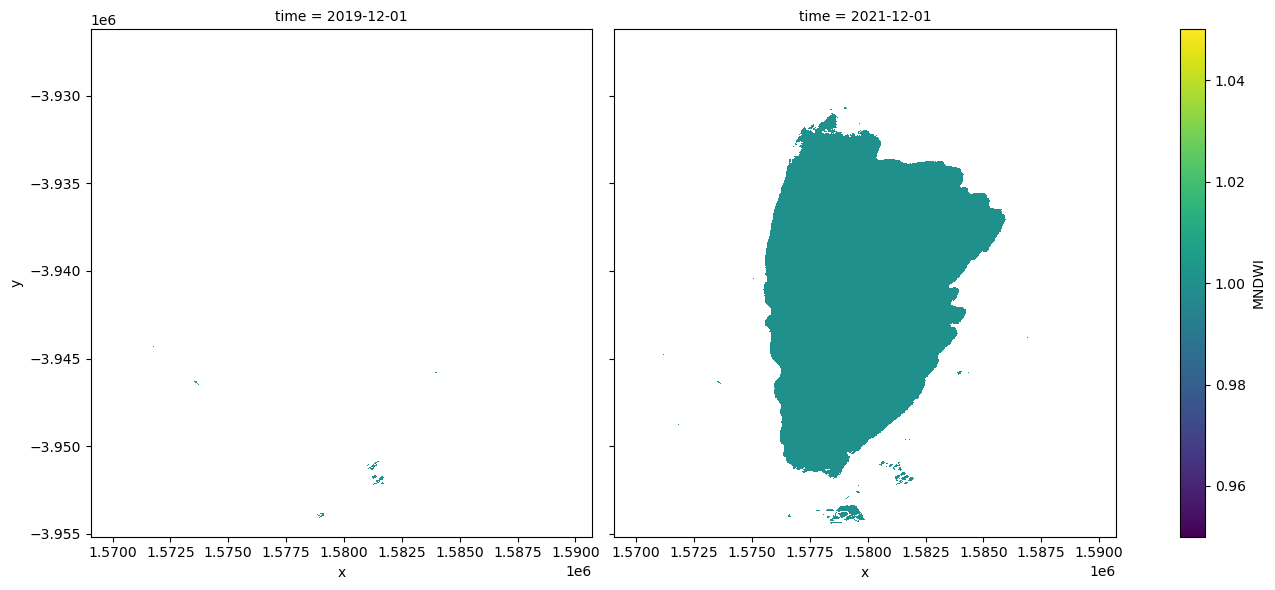

In [15]:
area_ds.sel(time=time_da).plot.imshow(col="time", col_wrap=2, figsize=(14, 6));

## Compare two time periods
The following cells determine the maximum extent of water for two different years. 

* `baseline_year` : The baseline year for the analysis
* `analysis_year` : The year to compare to the baseline year

In [16]:
baseline_time = "2019-03-01"
analysis_time = "2020-03-01"

baseline_ds, analysis_ds = ds_valid_water_area.sel(
    time=baseline_time, method="nearest"
), ds_valid_water_area.sel(time=analysis_time, method="nearest")

A new dataArray is created to store the new date from the `maximum water extent` for the two years

In [17]:
time_da = xr.DataArray(
    [baseline_ds.time.values, analysis_ds.time.values], dims=["time"]
)

## Plotting

Plot water extent of the MNDWI product for the two chosen periods.

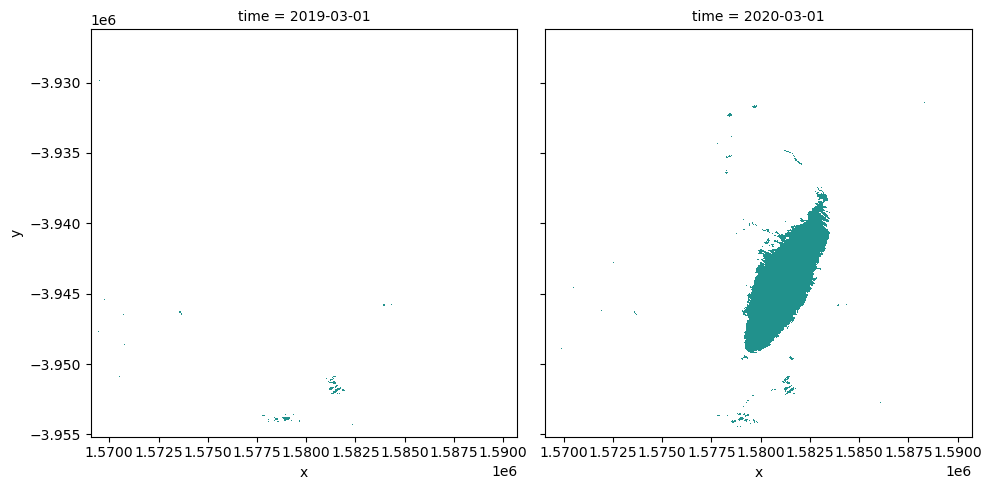

In [18]:
area_ds.sel(time=time_da).plot(
    col="time",
    col_wrap=2,
    robust=True,
    figsize=(10, 5),
    cmap="viridis",
    add_colorbar=False,
);

## Calculating the change for the two nominated periods
The cells below calculate the amount of water gain, loss and stable for the two periods

In [19]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_da)

analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))

water_disappeared = change.where(change == -1)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [20]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

## Plotting
The water variables are plotted to visualised the result

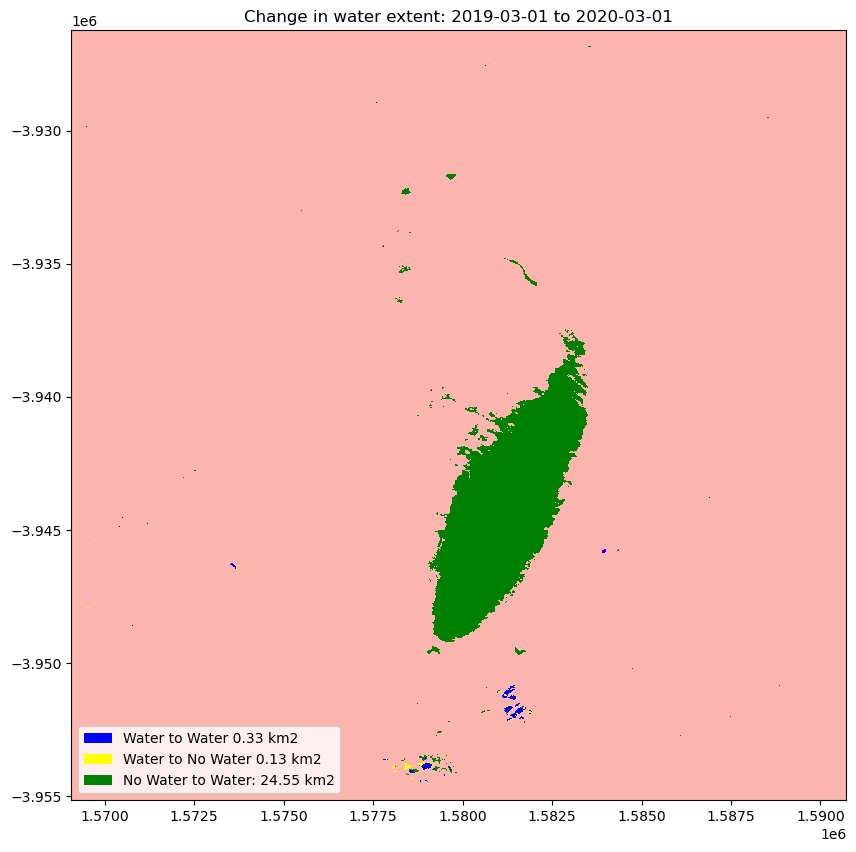

In [21]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ds_selected[1].plot.imshow(cmap="Pastel1", add_colorbar=False, add_labels=False, ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)

permanent_water.plot.imshow(
    cmap=ListedColormap([stable_color]), add_colorbar=False, add_labels=False, ax=ax
)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title(f"Change in water extent: {baseline_time} to {analysis_time}");

## Next steps


Return to the "Analysis parameters" section, modify some values (e.g. `lat`, `lon`, `start_year`, `end_year`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

Change the year also in "Compare Two Time Periods - a Baseline and an Analysis" section, (e.g. `base_year`, `analyse_year`) and re-run the analysis.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2023

**Compatible datacube version:**

In [22]:
print(datacube.__version__)

1.8.12


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](/genindex.html) -->